In [1]:
import numpy as np
import matplotlib.pyplot as mp
import scipy.fftpack as fft
import scipy.io.wavfile as wav
import scipy.stats as stat
import numpy.linalg as la
import numpy.random as rd
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error as mse
import cvxpy as cvx
import IPython.display as disp
import joblib as jl
import time, h5py
import datetime as date
from jupyterthemes import jtplot

In [2]:
jtplot.reset()
mp.style.use("seaborn-poster")
mp.rcParams["text.usetex"] = True
mp.rcParams["font.family"] = "serif"
mp.rcParams["figure.figsize"] = (5*16/9,5)
mp.rcParams["figure.dpi"] = 100
rd.seed(314)

In [3]:
"""Implementation of the Smoothed L0 Optimisation algorithm developed by Mohimani et al, see http://ee.sharif.edu/~SLzero/ for details."""

def gaussian_F(x_i, sigma):
    """Calculate the maximisation function f_{sigma} for an element of the vector x"""
    x = np.abs(x_i)
    return x_i * np.exp(-1*x*x/(2*sigma*sigma))

Fsigma_gauss = np.vectorize(gaussian_F, otypes=[np.float_]) #Vectorize the gaussian function

def SL0(A, b, **kwargs):
    """Function that performs the SL0 algorithm given the matrix A and b, and a minimum value of sigma.
    Arguments: 
     - A: numpy matrix
     - b: numpy matrix
     - sigma_min: Float, minimum value of the approximation parameter sigma. A sensible default is 1e-12
    Optional keyword arguments:
    - FSigma: vectorized function that takes an element of a vector, and the parameter sigma, as arguments. Defaults to
    the Gaussian form used by the authors
    - L: Number of steps of the gradient ascent step, defaults to 3
    - mu_0: Gradient in the gradient ascent step, defaults to 2
    - sigma_decrease: Amount by which the approximation parameter decreases each step
    """
    #Defaults for mu_0, L, decrease factor taken from the paper
    Fsigma = kwargs.pop('Fsigma', Fsigma_gauss)
    sigma_min = kwargs.pop("sigma_min", 1e-12)
    mu_0 = kwargs.pop('mu_0', 2)
    L = kwargs.pop('L', 3)
    sdf = kwargs.pop('sigma_decrease',0.5)
    A_plus = np.linalg.pinv(A)
    x = A_plus.dot(b)
    sigma = 2*np.max(np.abs(x))
    while sigma > sigma_min:
        for i in range(L): #Do L rounds of gradient ascent
            delta = Fsigma(x, sigma)
            x -= mu_0*delta
            x -= A_plus.dot(A.dot(x) - b)
        sigma *= sdf #Sigma decrease factor value chosen b the authors
    return np.around(x, decimals=10)

def get_frequency(ft, samprate):
    return np.argmax(abs(ft))/len(ft)*samprate

In [4]:
class compsenseFromFile:
    
    def __init__(self, filename, downsample=False, downrate=None):
        self.rate, self.data = wav.read(filename)
        self.filename = filename
        self.name = filename[:-4]
        
        if len(self.data.shape) > 1 and self.data.shape[1] > 1:
            self.data = self.data.mean(axis=1)
            
        self.N = len(self.data)
        self.dur = self.N/self.rate
        self.t = np.linspace(0, self.dur, self.N)
        self.coef = fft.fft(self.data)
        self.coefshift = fft.fftshift(self.coef)
        
        if downsample:
            self.downrate = downrate
            self.Nd = int(downrate*self.dur)
            nd = np.round(np.linspace(0, self.N-1, self.Nd)).astype(int)
            self.data = self.data[nd]
            self.t = self.t[nd]
            self.coef = fft.fft(self.data)
            self.coefshift = fft.fftshift(self.coef)
            self.rate = downrate
        else:
            self.Nd = self.N
            self.t = np.linspace(0, self.dur, self.Nd)
        
    def getDominantFrequency(coef, rate):
        return np.argmax(abs(coef))/len(coef)*rate
        
    def displayOriginal(self, save=False):
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, self.data, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("original signal, $f_s = %i$Sa/s"%(self.rate))

        f = np.linspace(0, self.rate, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.Nd//2], abs(self.coef)[:self.Nd//2])
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")
        
        if save:
            mp.savefig(self.name + "_original.png", dpi=300, bbox_inches="tight")

        mp.show()
        disp.Audio(self.data, rate=self.rate)
        
    def sampleCompressive(self, mode, rate):
        self.subrate = rate
        self.M = int(self.subrate*self.dur)
        
        if mode == "random":
            m = np.sort(rd.randint(0, self.Nd, self.M))
        elif mode == "subnyquist":
            m = np.round(np.linspace(0, self.Nd-1, self.M)).astype(int)
        else:
            raise ValueError("Specified mode is invalid")
        
        self.y = self.data[m]
        self.tm = self.t[m]
        self.compressedCoef = fft.fft(self.y)
        self.compressedCoefShift = fft.fftshift(self.compressedCoef)
        self.m = m
        
    def displayCompressed(self, save=False):
        y = self.to_int16(self.y)
        
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.tm, y, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("compressively sampled signal")

        f = np.linspace(0, self.subrate, self.M)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.M//2], abs(self.compressedCoef)[:self.M//2])
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        if save:
            mp.savefig(self.name + "_comp.png", dpi=300, bbox_inches="tight")
            wav.write(self.name + "_comp.wav", self.subrate, y)
        
        mp.show()
        disp.Audio(y, rate=self.subrate)
    
    def recovery(self, method, **method_kwargs):
        self.method = method
        d = fft.dct(np.identity(self.Nd))
        A = d[self.m]
        
        if method == "lasso":
            prob = skl.Lasso(**method_kwargs)
        elif method == "lassocv":
            prob = skl.LassoCV(**method_kwargs)
        elif method == "omp":
            prob = skl.OrthogonalMatchingPursuit(**method_kwargs)
        elif method == "sl0":
            prob = SL0(A, self.y)
            self.recoveredCoef = prob
            return
        else:
            raise ValueError("Specified method is invalid")
        
        prob.fit(A, self.y)
        self.recoveredCoef = prob.coef_
            
    def displayRecovered(self, save):
        xhat = fft.idct(self.recoveredCoef)
        xhat = self.to_int16(xhat)
        fig = mp.figure(figsize=(5*16/9*2, 5))

        ax = fig.add_subplot(121)
        ax.plot(self.t, xhat, lw=0.4)
        ax.set_xlabel("time, s")
        ax.set_ylabel("amplitude")
        ax.set_title("reconstructed signal")

        f = np.linspace(0, self.rate/2, self.Nd)
        ax = fig.add_subplot(122)
        ax.plot(f[:self.Nd//2], abs(self.recoveredCoef)[:self.Nd//2])
        ax.set_xlabel("frequency, Hz")
        ax.set_ylabel("density")
        ax.set_title("Frequency spectrum")

        if save:
            mp.savefig(self.name + "_recon_" + self.method + ".png", dpi=300, bbox_inches="tight")
            wav.write(self.name + "_recon_" + self.method + ".wav", self.rate, xhat)
        
        mp.show()
        disp.Audio(self.y, rate=self.rate)
        self.xhat = xhat
        
    def to_int16(self, sig):
        return np.round(sig/abs(sig).max() * ((2**16 - 1)//2)).astype("int16")
    
    def get_psnr(self):
        return 20*np.log10((2**16/2 - 1)/np.sqrt(mse(self.data, self.xhat)))
        
    def run_all(self, mode, rate, save, method, **method_kwargs):
        self.displayOriginal(save)
        self.sampleCompressive(mode, rate)
        self.displayCompressed(save)
        self.recovery(method, **method_kwargs)
        self.displayRecovered(save)

## Low E only

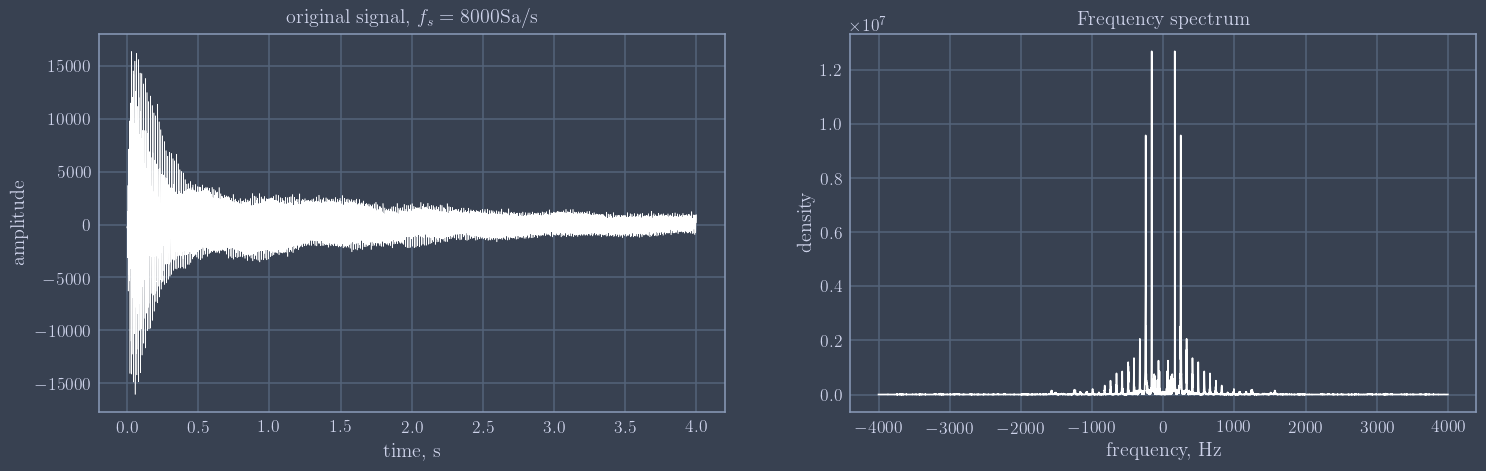

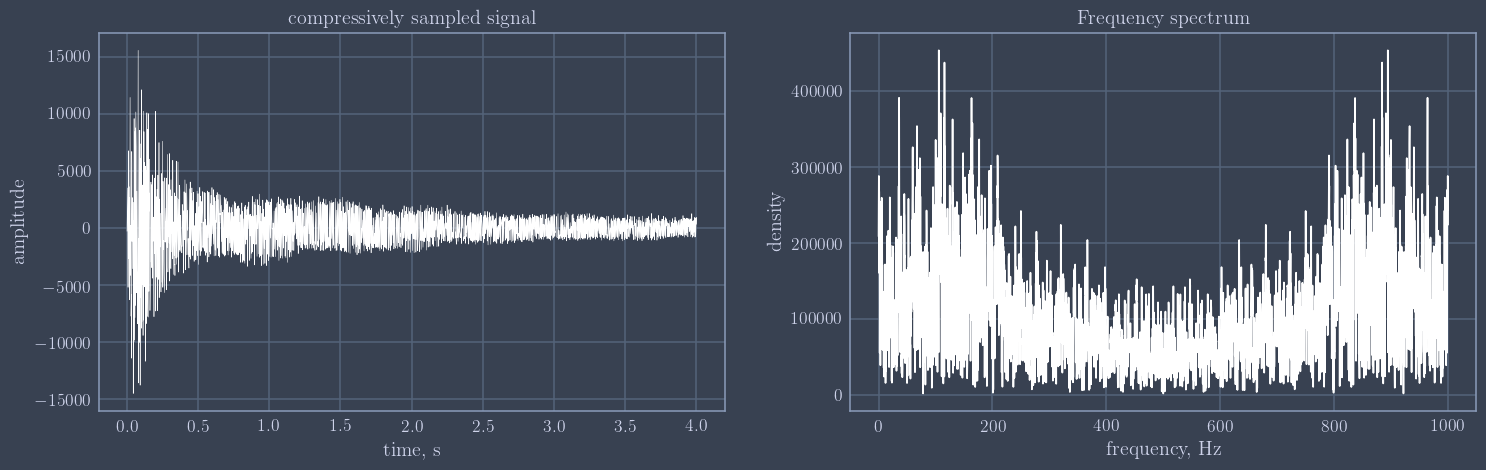

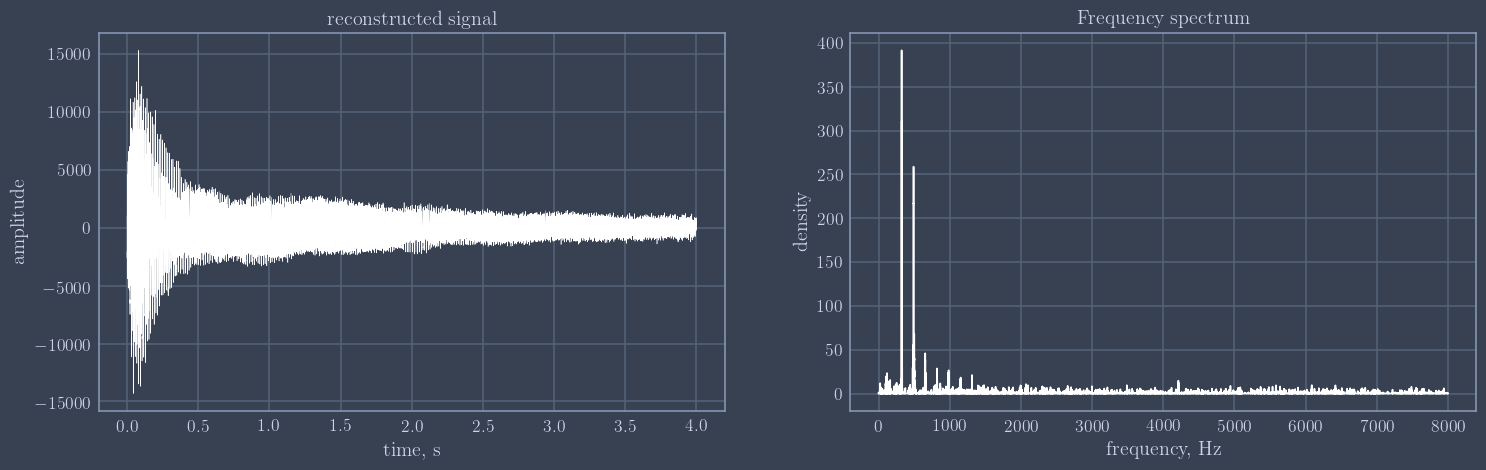

In [9]:
E6 = compsenseFromFile("E6.wav")
E6.run_all("random", 1000, "lasso", alpha=1.0)

In [13]:
disp.Audio(E6.data, rate=E6.rate)

In [14]:
disp.Audio(E6.y, rate=E6.subrate)

In [15]:
disp.Audio(E6.xhat, rate=E6.rate)

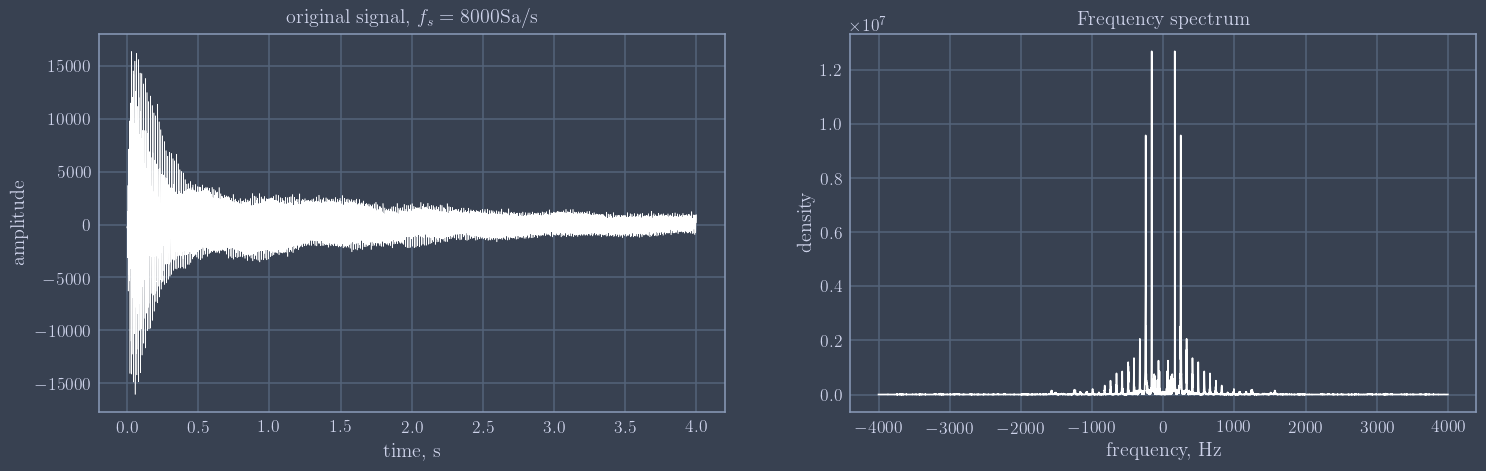

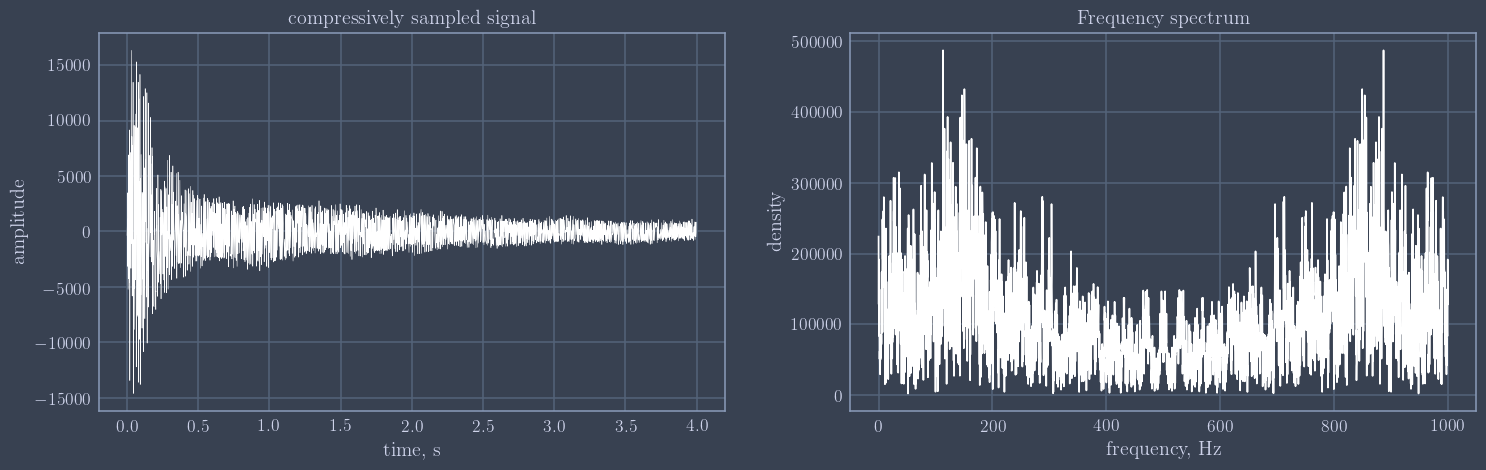

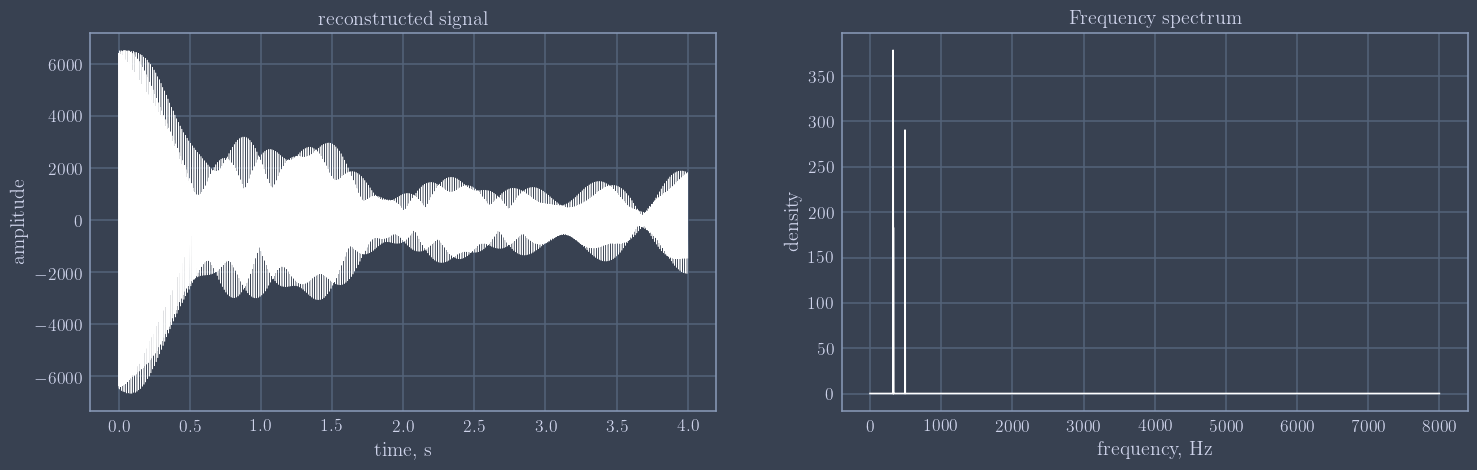

In [36]:
E6 = compsenseFromFile("E6.wav")
E6.run_all("random", 1000, "omp", n_nonzero_coefs=20)

In [38]:
disp.Audio(E6.data, rate=E6.rate)

In [37]:
disp.Audio(E6.xhat, rate=E6.rate)

## High E only

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


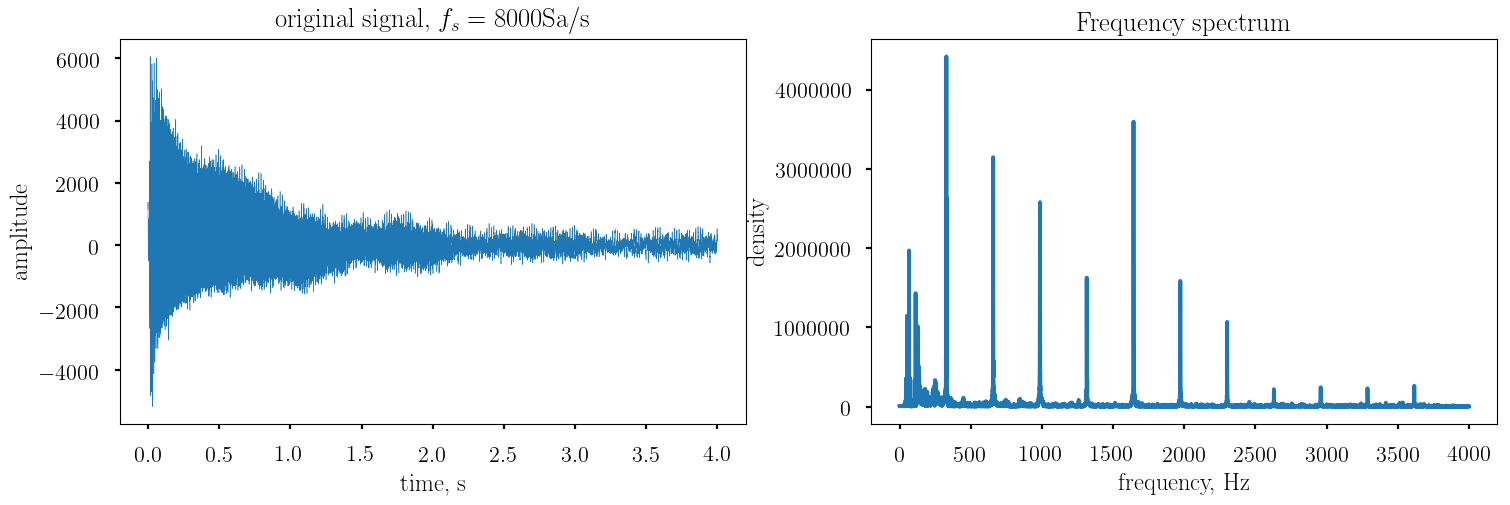

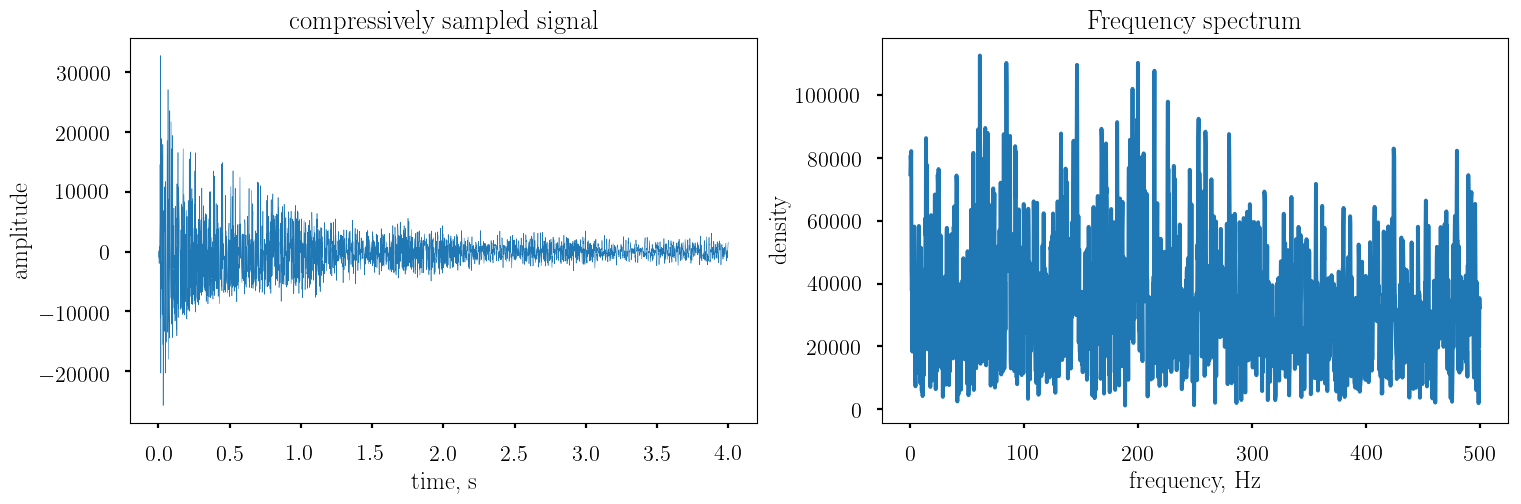

In [5]:
E1 = compsenseFromFile("E1.wav")
E1.displayOriginal(False)
E1.sampleCompressive("random", 1000)
E1.displayCompressed(False)
# E1.run_all("random", 1000, True, "lasso", alpha=1.0)
# np.save("E1_recovered.npy", E1.recoveredCoef)

In [17]:
disp.Audio(E1.data, rate=E1.rate)

In [18]:
disp.Audio(E1.y, rate=E1.subrate)

In [19]:
disp.Audio(E1.xhat, rate=E1.rate)

## high E + low E

D:\ProgramData\Anaconda3\envs\compsense\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


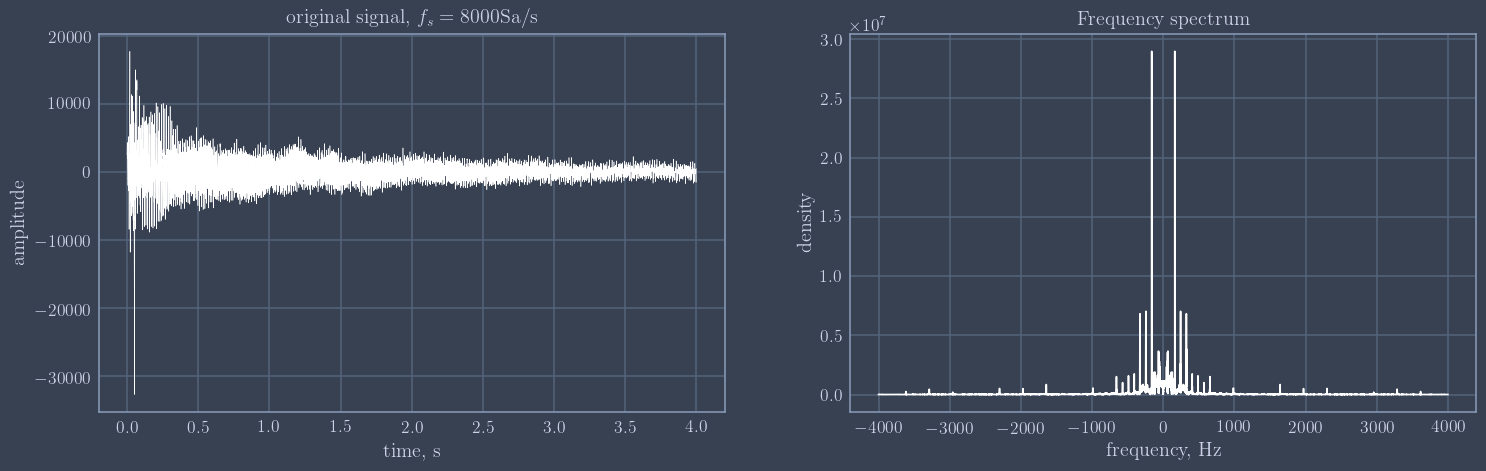

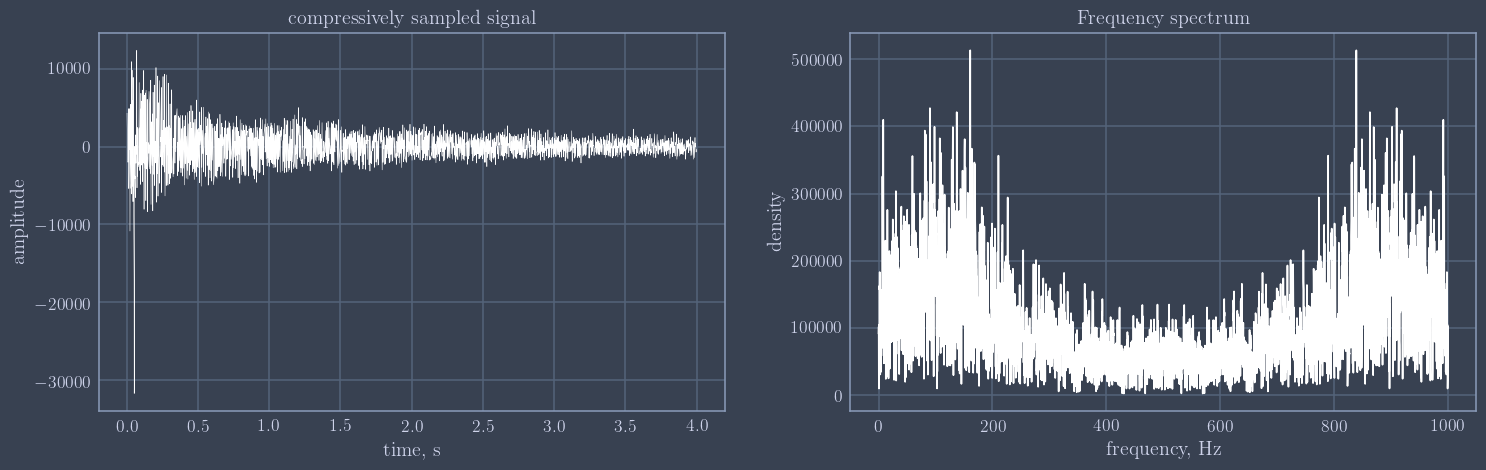

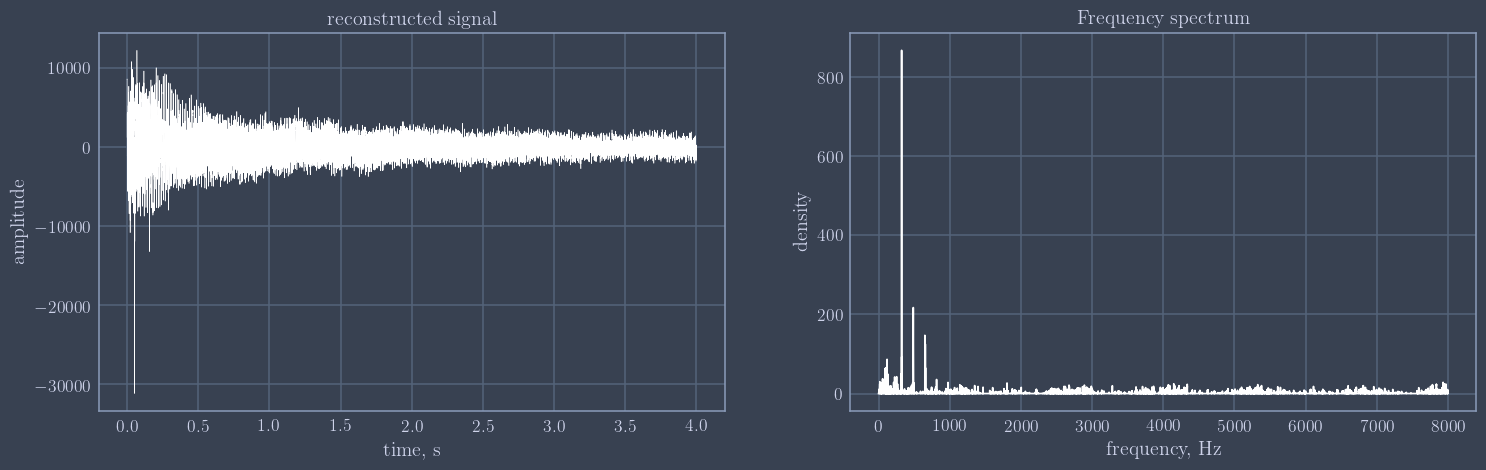

In [28]:
E16 = compsenseFromFile("E1 + E6.wav")
E16.run_all("random", 1000, "lasso", alpha=1.0)

In [33]:
disp.Audio(E16.data, rate=E16.rate)

In [34]:
disp.Audio(E16.y, rate=E16.subrate)

In [35]:
disp.Audio(E16.xhat, rate=E16.rate)